In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_124450/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
# CODE FOR hybrid letkf 1st iteration vs speedy

import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)

# Define: Initial FILES, dates, Variable, and Level desired

analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_analysis_81_12.nc'
# plot 29 year analysis of 1 iterative
analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/iterative1_hybrid_1_5_1_3_19810101_20100101/mean.nc'
# spread_file =  '/skydata2/troyarcomano/letkf-hybrid-speedy/experiments/hybrid_first_test/anal_sprd.nc'
start_year = 1981
end_year = 2009

startdate = datetime(start_year,1,1,0)
enddate = datetime(end_year,12,31,18)
time_slice = slice(startdate,enddate)

level = 0.95 #0.2#0.95#0.51
level_era = 7 #2#7 #4

var_era = 'Specific_Humidity'#'Temperature' #'V-wind'
var_da =  'q'#'t'#'v'
print('you selected for variable =',var_era)
print('at level =',level)
timestep_6hrly = 6


# create empty list to store indiviudal datasets
era5sets = []
print('made it to the for loop...')

# LOAD DATA HERE 
print('LOADING DATA...')

# loop over the range of years and open each ds
for year in range(start_year, end_year + 1):
    nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
    # only load var_era selected and only load level_era selected from above
    ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
    # Read in every 6th timestep
    ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
    era5sets.append(ds_nature)
    
print('Now its concatinating them all together...')

ds_nature = xr.concat(era5sets, dim = 'Timestep')
ds_nature = ds_nature.sortby('Timestep')
print('Done concat and sortby Timestep...')
temp_500_nature = ds_nature.values

ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)
#ds_spread = xr.open_dataset(spread_file)

temp_500_analysis = ds_analysis_mean
# temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
temp_500_analysis_speedy = ds_analysis_mean_speedy
# temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
# temp_500_spread = ds_spread[var_da].sel(lev=level).values

print('era5 shape = ',np.shape(temp_500_nature))
print('speedy shape = ',np.shape(temp_500_analysis_speedy))
print('hybrid shape = ',np.shape(temp_500_analysis))

#find smallest index value to set that as the "length"
speedy_index = temp_500_analysis_speedy.shape[0]
nature_index = temp_500_nature.shape[0]
hybrid_index = temp_500_analysis.shape[0]
smallest_index = min(speedy_index,nature_index,hybrid_index)

if smallest_index == speedy_index:
    length = speedy_index #- 1
elif smallest_index == nature_index:
    length = nature_index
else:
    length = hybrid_index
print('the smallest length is',length)

#ps_nature = ds_nature['logp'].values
#ps_nature = 1000.0 * np.exp(ps_nature)
#ps_analysis = ds_analysis_mean['ps'].values/100.0

xgrid = 96
ygrid = 48

analysis_rmse = np.zeros((length))
analysis_rmse_speedy = np.zeros((length))
#global_average_ensemble_spread= np.zeros((length))
#ps_rmse = np.zeros((length))

analysis_error = np.zeros((length,ygrid,xgrid))
analysis_error_speedy = np.zeros((length,ygrid,xgrid))

print(np.shape(analysis_error))
print(np.shape(analysis_error_speedy))

print('Now its calculating analysis RMSE for every 6hr timestep...')

lats = ds_nature.Lat
for i in range(length):
    analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
    analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
    #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
    analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])

print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP...')

print('Done.')

you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (42368, 48, 96)
speedy shape =  (42368, 48, 96)
hybrid shape =  (42368, 48, 96)
the smallest length is 42368
(42368, 48, 96)
(42368, 48, 96)
Now its calculating analysis RMSE for every 6hr timestep...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP...
Done.


Now plotting and meshing...
Specific Humidity


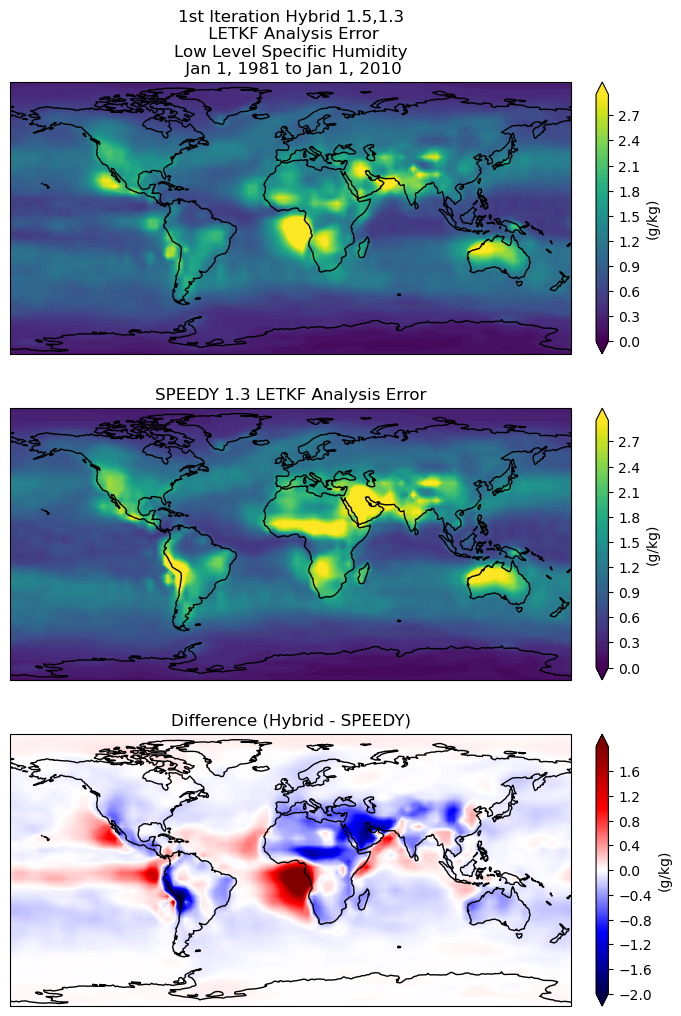

In [5]:
# MAKE MAP FROM ABOVE 

''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
  
averaged_error = np.average(abs(analysis_error[24::,:,:]),axis=0)
averaged_error_speedy = np.average(abs(analysis_error_speedy[24::,:,:]),axis=0)

lat = ds_analysis_mean.lat.values
lon = ds_analysis_mean.lon.values

lons2d, lats2d = np.meshgrid(lon,lat)

print('Now plotting and meshing...')

fig = plt.figure(figsize=(8,12))
''' ax1 ===>  Makes map of hybrid letkf analysis error  '''
ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
ax1.coastlines()

''' Multiply averaged_error by 1000 for spec_humid only'''

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

if var_era == 'Temperature':
    units='(K)'
if var_era == 'Specific_Humidity':
    units='(g/kg)'
if var_era == 'V-wind':
    units='(m/s)'
    
if level == .95:
    title_level = 'Low Level '
if level == .2:
    title_level = '200 hPa '
    
if var_era == 'Specific_Humidity':
    title_var_era = 'Specific Humidity'
if var_era == 'V-wind':
    title_var_era = "Meridional Wind"
if var_era == 'Temperature':
    title_var_era = 'Temperature'
print(title_var_era)

if level == .95 and var_era == 'Temperature':
    adapted_range = np.arange(0,5.05,.05)
    adapted_difference_range = np.arange(-5,5,.05)
    
if level == .2 and var_era == 'Temperature':
    adapted_range = np.arange(0,.1,.001)
    adapted_difference_range = np.arange(-.05,.05,.001)

if level == .95 and var_era == 'Specific_Humidity':
    adapted_range = np.arange(0,3,.05)
    adapted_difference_range = np.arange(-2,2,.001)
    
if level == .2 and var_era == 'Specific_Humidity':
    adapted_range = np.arange(0,.1,.001)
    adapted_difference_range = np.arange(-.05,.05,.001)
    
if level == .2 and var_era == 'V-wind':
    adapted_range = np.arange(0,10.05,.05)
    adapted_difference_range = np.arange(-2,2.1,.05)
    
cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)

plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
ax1.set_title('1st Iteration Hybrid 1.5,1.3\n LETKF Analysis Error\n'+ title_level +  title_var_era + '\n Jan 1, 1981 to Jan 1, 2010')

'''ax2 ===>  makes plot of speedy letkf analysis error '''
ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
ax2.coastlines()

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=adapted_range,extend='both')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
ax2.set_title('SPEEDY 1.3 LETKF Analysis Error')

diff = averaged_error - averaged_error_speedy
cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

'''ax3 ==> Makes map of difference of hybrid and speedy '''

ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Difference (Hybrid - SPEEDY)')
# high_level_difference_range = np.arange(-.05,.05,.001)
low_level_difference_range = np.arange(-5,5,.05)

cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=adapted_difference_range,extend='both',cmap='seismic')

#cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=np.arange(-5,5.1,.5),extend='both',cmap='seismic')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
plt.show()
#plt.savefig('/skydata2/dylanelliott/letkf-hybrid-speedy/scripts/annual_report_23_plots/Low_Level_Specific_Humidity_map.jpeg',dpi=1200)

avg speedy = 0.00159169950336451
average hybrid = 0.0014803382958630523
average percent change =  -6.996371316700431
Specific_Humidity  and  0.95
Specific Humidity


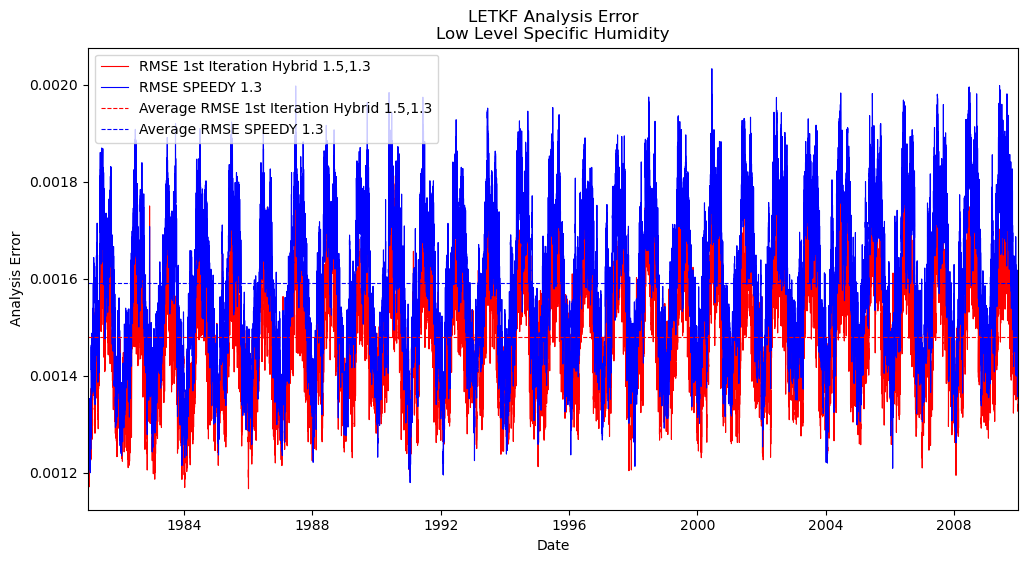

In [6]:
# MAKE TIME SERIES

''' 
percent change '''
average_hybrid = np.average(analysis_rmse[20::])
average_speedy = np.average(analysis_rmse_speedy[20::])
percent_change = ((average_hybrid - average_speedy) / average_speedy ) * 100

print('avg speedy =',average_speedy)
print('average hybrid =', average_hybrid)
print('average percent change = ',percent_change)
print(str(var_era),' and ',str(level))

#print('Average RMSE Surface Pressure (hPa)',np.average(ps_rmse))
#print('Average RMSE Variable',np.average(ps_rmse))
x = np.arange(0,length)

base = startdate
plt.figure(figsize=(12,6))
#
# ANALYSIS HYBRID is. iterative1_speedystatesfixed_offbyonebugfixed_hybrid_1_5_1_3
#
date_list = [base + timedelta(days=x/4) for x in range(length)]
width = .8
plt.plot(date_list,analysis_rmse,color='r',lw = width,label='RMSE 1st Iteration Hybrid 1.5,1.3') #cov-infl1.3
plt.plot(date_list,analysis_rmse_speedy,color='b',lw=width,label='RMSE SPEEDY 1.3')
plt.axhline(y=np.average(analysis_rmse[20::]), color='r',lw=width, linestyle='--',label="Average RMSE 1st Iteration Hybrid 1.5,1.3")
plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b',lw=width, linestyle='--',label="Average RMSE SPEEDY 1.3")

if level == .95:
    title_level = 'Low Level '
if level == .2:
    title_level = '200 hPa '
    
if var_era == 'Specific_Humidity':
    title_var_era = 'Specific Humidity'
if var_era == 'V-wind':
    title_var_era = "Meridional Wind"
if var_era == 'Temperature':
    title_var_era = 'Temperature'
print(title_var_era)
plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
#plt.title('Ensemble Spread\nModel Level 4 Temperature')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Analysis Error')
#plt.ylabel('Analysis Error (kg/kg)')
#plt.ylabel('Ensemble Spread (K)')
plt.xlim([startdate, enddate])
# plt.ylim(3,7,.25)
plt.show()
#plt.savefig('/skydata2/dylanelliott/letkf-hybrid-speedy/scripts/annual_report_23_plots/Low_Level_Specific_Humidity_time_series.jpeg',dpi=1200)

In [6]:
# PLOT 2iteration TO COMPARE

# Define: Initial FILES, dates, Variable, and Level desired

# analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/uniform_analysis_2011_01_to_2012_05.nc'
analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/iterative2_hybrid_1_5_1_3_1_3_20110101_20120101/mean.nc'
# spread_file =  '/skydata2/troyarcomano/letkf-hybrid-speedy/experiments/hybrid_first_test/anal_sprd.nc'
start_year = 2011
end_year = 2011

startdate = datetime(start_year,1,1,0)
enddate = datetime(2011,12,31,18)
time_slice = slice(startdate,enddate)


print('you selected for variable =',var_era)
print('at level =',level)
timestep_6hrly = 6


# create empty list to store indiviudal datasets
era5sets = []
print('made it to the for loop...')

# LOAD DATA HERE 
print('LOADING DATA...')

# loop over the range of years and open each ds
for year in range(start_year, end_year + 1):
    nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
    # only load var_era selected and only load level_era selected from above
    ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
    # Read in every 6th timestep
    ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
    era5sets.append(ds_nature)
    
print('Now its concatinating them all together...')

ds_nature = xr.concat(era5sets, dim = 'Timestep')
ds_nature = ds_nature.sortby('Timestep')
print('Done concat and sortby Timestep...')
temp_500_nature = ds_nature.values

ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)
#ds_spread = xr.open_dataset(spread_file)

temp_500_analysis = ds_analysis_mean
# temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
temp_500_analysis_speedy = ds_analysis_mean_speedy
# temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
# temp_500_spread = ds_spread[var_da].sel(lev=level).values

print('era5 shape = ',np.shape(temp_500_nature))
print('speedy shape = ',np.shape(temp_500_analysis_speedy))
print('hybrid shape = ',np.shape(temp_500_analysis))

#find smallest index value to set that as the "length"
speedy_index = temp_500_analysis_speedy.shape[0]
nature_index = temp_500_nature.shape[0]
hybrid_index = temp_500_analysis.shape[0]
smallest_index = min(speedy_index,nature_index,hybrid_index)

if smallest_index == speedy_index:
    length = speedy_index #- 1
elif smallest_index == nature_index:
    length = nature_index
else:
    length = hybrid_index
print('the smallest length is',length)

#ps_nature = ds_nature['logp'].values
#ps_nature = 1000.0 * np.exp(ps_nature)
#ps_analysis = ds_analysis_mean['ps'].values/100.0

xgrid = 96
ygrid = 48
#length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

analysis_rmse2 = np.zeros((length))
analysis_rmse_speedy = np.zeros((length))
#global_average_ensemble_spread= np.zeros((length))
#ps_rmse = np.zeros((length))

analysis_error2 = np.zeros((length,ygrid,xgrid))
analysis_error_speedy = np.zeros((length,ygrid,xgrid))

print(np.shape(analysis_error2))
print(np.shape(analysis_error_speedy))

print('Now its calculating analysis RMSE for every 6hr timestep...')

lats = ds_nature.Lat
for i in range(length):
    analysis_rmse2[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
    analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
    #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    analysis_error2[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
    analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])

print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP...')

print('Done.')

you selected for variable = Temperature
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE for every 6hr timestep...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP...
Done.


Now plotting and meshing...
Temperature


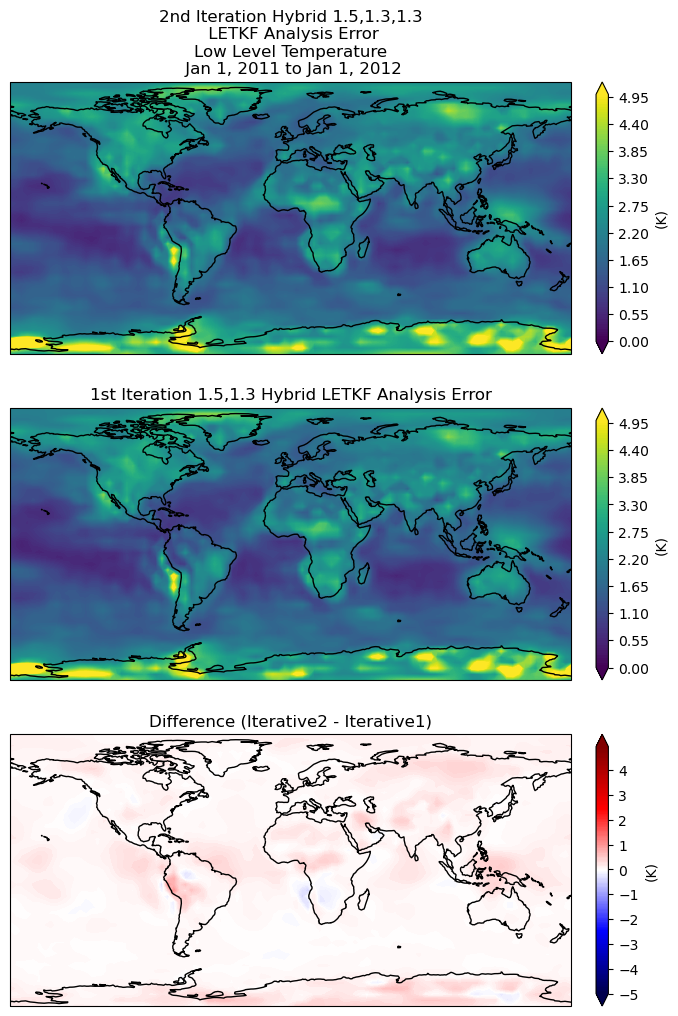

In [7]:
# MAKE MAP compare iterative 2 vs iterative 1 

''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
  
averaged_error2 = np.average(abs(analysis_error2[24::,:,:]),axis=0)
# averaged_error_speedy = np.average(abs(analysis_error_speedy[24::,:,:]),axis=0)

lat = ds_analysis_mean.lat.values
lon = ds_analysis_mean.lon.values

lons2d, lats2d = np.meshgrid(lon,lat)

print('Now plotting and meshing...')

fig = plt.figure(figsize=(8,12))
''' ax1 ===>  Makes map of hybrid letkf analysis error  '''
ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
ax1.coastlines()

''' Multiply averaged_error by 1000 for spec_humid only'''

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error2, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

low_level_range = np.arange(0,5.05,.05)
high_level_range = np.arange(0,.1,.001)


if level == .95:
    title_level = 'Low Level '
if level == .2:
    title_level = '200 hPa '
    
if var_era == 'Specific_Humidity':
    title_var_era = 'Specific Humidity'
if var_era == 'V-wind':
    title_var_era = "Meridional Wind"
if var_era == 'Temperature':
    title_var_era = 'Temperature'
    
if var_era == 'Temperature':
    units='(K)'
if var_era == 'Specific_Humidity':
    units='(g/kg)'
if var_era == 'V-wind':
    units='(m/s)'
    
cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=low_level_range,extend='both')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)    
print(title_var_era)
plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
ax1.set_title('2nd Iteration Hybrid 1.5,1.3,1.3\n LETKF Analysis Error\n'+ title_level +  title_var_era + '\n Jan 1, 2011 to Jan 1, 2012')

diff = averaged_error2 - averaged_error
cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
'''ax2 ===>  makes plot of iterative2 letkf analysis error '''
ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
ax2.coastlines()

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=low_level_range,extend='both')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
ax2.set_title('1st Iteration 1.5,1.3 Hybrid LETKF Analysis Error')

diff = averaged_error2 - averaged_error
cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

'''ax3 ==> Makes map of difference of hybrid and speedy '''

ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Difference (Iterative2 - Iterative1)')
# high_level_difference_range = np.arange(-.05,.05,.001)
low_level_difference_range = np.arange(-5,5,.05)

cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=low_level_difference_range,extend='both',cmap='seismic')

#cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=np.arange(-5,5.1,.5),extend='both',cmap='seismic')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
plt.show()

Now plotting and meshing...
Temperature


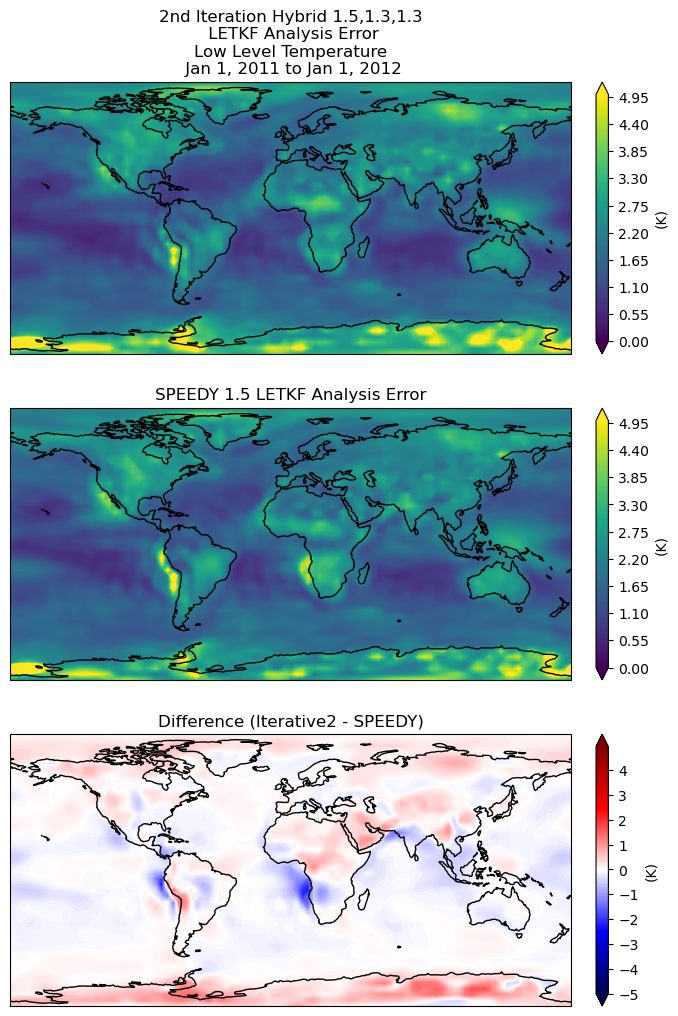

In [8]:
# MAKE MAP compare iterative 2 vs SPEEDY NOW

''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
  
averaged_error2 = np.average(abs(analysis_error2[24::,:,:]),axis=0)
# averaged_error_speedy = np.average(abs(analysis_error_speedy[24::,:,:]),axis=0)

lat = ds_analysis_mean.lat.values
lon = ds_analysis_mean.lon.values

lons2d, lats2d = np.meshgrid(lon,lat)

print('Now plotting and meshing...')

fig = plt.figure(figsize=(8,12))
''' ax1 ===>  Makes map of iterative2 hybrid letkf analysis error  '''
ax1 = plt.subplot(311,projection=ccrs.PlateCarree())
ax1.coastlines()

''' Multiply averaged_error by 1000 for spec_humid only'''

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error2, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

low_level_range = np.arange(0,5.05,.05)
high_level_range = np.arange(0,.1,.001)


if level == .95:
    title_level = 'Low Level '
if level == .2:
    title_level = '200 hPa '
    
if var_era == 'Specific_Humidity':
    title_var_era = 'Specific Humidity'
if var_era == 'V-wind':
    title_var_era = "Meridional Wind"
if var_era == 'Temperature':
    title_var_era = 'Temperature'
    
if var_era == 'Temperature':
    units='(K)'
if var_era == 'Specific_Humidity':
    units='(g/kg)'
if var_era == 'V-wind':
    units='(m/s)'
    
cf = ax1.contourf(lons2d, lats2d,cyclic_data,levels=low_level_range,extend='both')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)    
print(title_var_era)
plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)
ax1.set_title('2nd Iteration Hybrid 1.5,1.3,1.3\n LETKF Analysis Error\n'+ title_level +  title_var_era + '\n Jan 1, 2011 to Jan 1, 2012')

# diff = averaged_error2 - averaged_error_speedy
# cyclic_data, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
# lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
'''ax2 ===>  makes plot of iterative1 letkf analysis error '''
ax2 = plt.subplot(312,projection=ccrs.PlateCarree())
ax2.coastlines()

cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

cf = ax2.contourf(lons2d, lats2d,cyclic_data,levels=low_level_range,extend='both')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
ax2.set_title('SPEEDY 1.5 LETKF Analysis Error')


'''ax3 ==> Makes map of difference of hybrid and speedy '''

diff = averaged_error2 - averaged_error_speedy
cyclic_data, cyclic_lons = add_cyclic_point(diff, coord=lon)
lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
ax3 = plt.subplot(313,projection=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Difference (Iterative2 - SPEEDY)')
# high_level_difference_range = np.arange(-.05,.05,.001)
low_level_difference_range = np.arange(-5,5,.05)

cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=low_level_difference_range,extend='both',cmap='seismic')

#cf = ax3.contourf(lons2d, lats2d,cyclic_data,levels=np.arange(-5,5.1,.5),extend='both',cmap='seismic')
plt.colorbar(cf,label=units,fraction=0.046, pad=0.04)
plt.show()

avg speedy = 2.390244023501873
average hybrid = 2.3043046118484605
average percent change =  -3.595424182988031
Temperature  and  0.95
Temperature


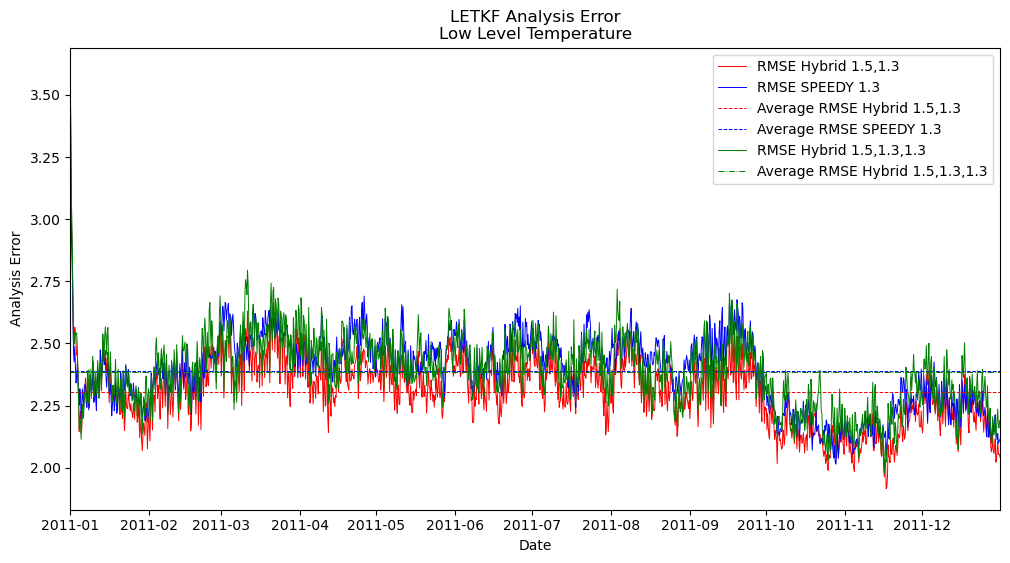

In [10]:
# MAKE TIME SERIES COMPARE HYBRIDS

''' 
percent change '''
# average_hybrid = np.average(analysis_rmse[20::])
# average_speedy = np.average(analysis_rmse_speedy[20::])
# percent_change = ((average_hybrid - average_speedy) / average_speedy ) * 100

print('avg speedy =',average_speedy)
print('average hybrid =', average_hybrid)
print('average percent change = ',percent_change)
print(str(var_era),' and ',str(level))

#print('Average RMSE Surface Pressure (hPa)',np.average(ps_rmse))
#print('Average RMSE Variable',np.average(ps_rmse))
x = np.arange(0,length)

base = startdate
plt.figure(figsize=(12,6))
date_list2 = [base + timedelta(days=x/4) for x in range(length)]
linewidth = .7

plt.plot(date_list2,analysis_rmse,color='r',lw=linewidth,label='RMSE Hybrid 1.5,1.3') #cov-infl1.3
plt.plot(date_list2,analysis_rmse_speedy,color='b',lw=linewidth,label='RMSE SPEEDY 1.3')
plt.axhline(y=np.average(analysis_rmse[20::]), color='r', linestyle='--',lw=linewidth,label="Average RMSE Hybrid 1.5,1.3")
plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b', linestyle='--',lw=linewidth,label="Average RMSE SPEEDY 1.3")
plt.plot(date_list,analysis_rmse2,color='g',lw=linewidth,label='RMSE Hybrid 1.5,1.3,1.3') #cov-infl1.3
plt.axhline(y=np.average(analysis_rmse2[20::]), color='g', linestyle='-.',lw=linewidth,label="Average RMSE Hybrid 1.5,1.3,1.3")

if level == .95:
    title_level = 'Low Level '
if level == .2:
    title_level = '200 hPa '
    
if var_era == 'Specific_Humidity':
    title_var_era = 'Specific Humidity'
if var_era == 'V-wind':
    title_var_era = "Meridional Wind"
if var_era == 'Temperature':
    title_var_era = 'Temperature'
print(title_var_era)
plt.title('LETKF Analysis Error\n' + title_level +  title_var_era)

# plt.title('LETKF Analysis Error\n Low Leve')
#plt.title('Ensemble Spread\nModel Level 4 Temperature')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Analysis Error')
#plt.ylabel('Analysis Error (kg/kg)')
#plt.ylabel('Ensemble Spread (K)')
plt.xlim([startdate, enddate])
# plt.ylim(1,5,.25)
plt.show()